In [2]:
#allow for autoreload of packages
%load_ext autoreload
%autoreload 2

In [3]:
from iqm.qiskit_iqm import IQMProvider, IQMFakeAdonis
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

import numpy as np
import os

# package imports
import grover_circuit_generator_2q as circ_gen
import utils as utils

In [8]:
# Set the backend
backend_id = 'none'

if backend_id == 'Helmi':
    HELMI_CORTEX_URL = os.getenv('HELMI_CORTEX_URL')
    provider = IQMProvider(HELMI_CORTEX_URL)
    backend = provider.get_backend()


# Fake Helmi backend
backend_fake = IQMFakeAdonis()

# Ideal backend
ideal_simulator =  AerSimulator()

In [9]:
# Set up parameters
shots = 10000

# Grover's Search Algorithm 

Grover's Search Algorithm [1](#References), introduced by Lov Grover in 1996, is one of the most important quantum algorithms due to its ability to search an unsorted database significantly faster than any classical algorithms. In classical computing, searching for a specific item among $N$ unsorted elements requires $O(N)$ steps. However, Grover's algorithm can achieve this in just $O(\sqrt{N})$ steps, providing a quadratic speedup. This remarkable efficiency is obtained by the unique properties of quantum computing: superposition and entanglement. These properties allow the algorithm to explore multiple possibilities simultaneously, therefore reducing the number of iterations needed to find the target item.

## 2-Bit Grover's Search

1. **Initialization**: The algorithm begins by initializing the qubits in the superposition of all possible states. This is achieved by applying Hadamard gates to each qubit, creating an equal probability amplitude across all states.

$$ \ket{\psi} = H \otimes H \ket{00} = \frac{1}{2}(\ket{00} + \ket{01} + \ket{10} + \ket{11})$$

2. **Oracle Application**: An oracle is a quantum gate that identifies the marked state by flipping its phase. This operation changes the sign of the amplitude of the marked state, distinguishing it from the others.

    For the marked state $\ket{b_i b_j}$ where ${bi, bj} \in \{0, 1\}$ , the oracle circuit are built as follows:

    $$ \text{O}_{b_i b_j} = \text{X}^{1 - b_i} \otimes \text{X}^{1 - b_j} \circ \text{CZ}_{12} \circ \text{X}^{1 - b_i} \otimes \text{X}^{1 - b_j} $$

    For example, the oracle code for $\ket{01}$ is given by:

    $$ \text{O}_{01} = \text{X} \otimes I \circ \text{CZ}_{12} \circ \text{X} \otimes I = X_1 \circ CZ_{12} \circ X_1 $$

    Then the state vector would become: 

    $$ \ket{\psi} = \frac{1}{2}(\ket{00} - \ket{01} + \ket{10} + \ket{11})$$

3. **Amplitude Amplification**: Here is the powerful magic of quantum computing that increase the search process to be quadratic speed up. This step, often referred to as the "Grover diffusion operator," amplifies the probability amplitude of the marked state. The operators reflects the amplitude of the states around the average amplitude of all states. This amplification stage is performed by:

$$ A = H^{\otimes 2} \circ X^{\otimes 2} \circ \text{CZ}_{12} \circ X^{\otimes 2} \circ H^{\otimes 2} = H^{\otimes 2} \circ O_{00} \circ H^{\otimes 2}$$

4. **Measurement**: After a sufficient number of iterations (in this case, only one iteration is needed for 2-bit Grover's search), the quantum state is measured. The result of the measurement will most likely be the marked state, due to the increased probability amplitude. In the example above, the measurement result would most likely yield '01'.

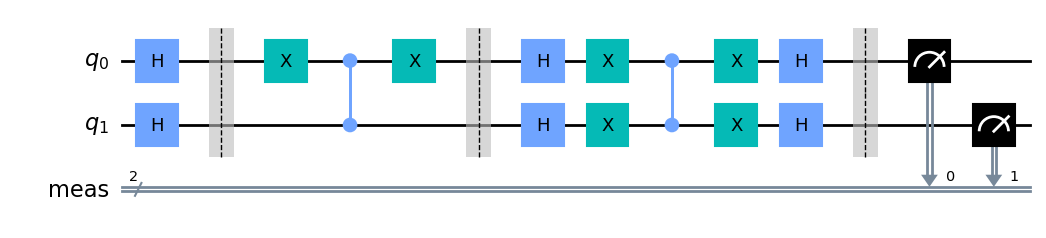

In [6]:
qc = circ_gen.create_grover_unenc_circuit('01', 2)
qc.measure_all()
qc.draw(fold=-1, output='mpl', style='clifford')

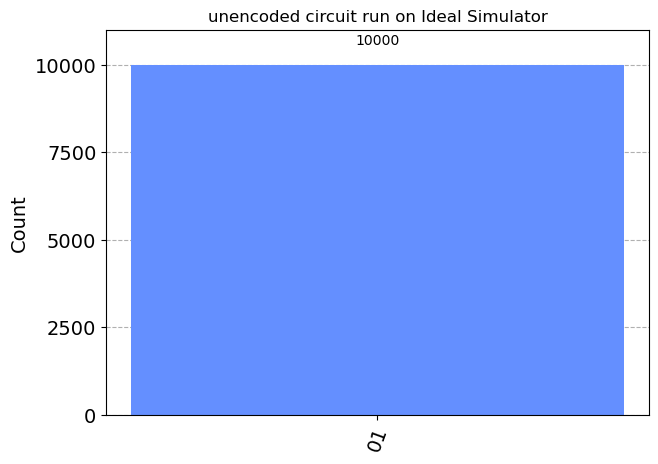

In [7]:
# Run the circuit on the ideal simulator
reversed_counts, plot_title = utils.run_a_circuit(qc, ideal_simulator, 'unencoded', shots)
plot_histogram(reversed_counts, title=plot_title)

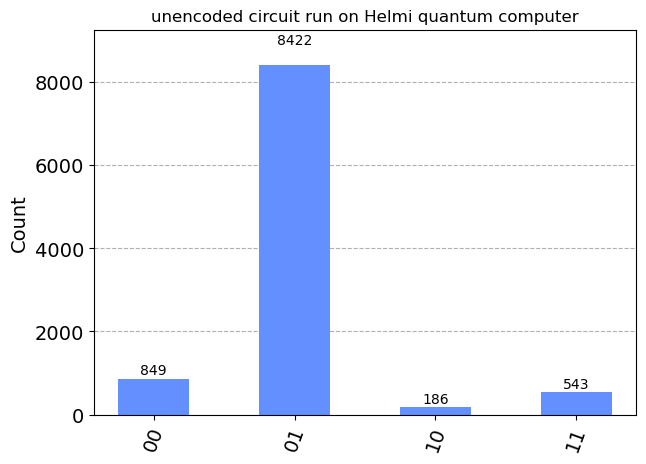

In [8]:
# Run the circuit on the Helmi QPU
reversed_counts, plot_title = utils.run_a_circuit(qc, backend, 'unencoded', shots)
plot_histogram(reversed_counts, title=plot_title)

# Better performance by encoded into [[4, 2, 2]] code 

While Grover's algorithm is powerful, it is also sensitive to errors that can occur during quantum computation. These errors can arise from various sources, including qubit decoherence, gate imperfections, and environmental noise. To detect these errors occuring during the circuit, we can utilize quantum error-detecting codes like the \[[4,2,2]] code [4](#References). 

## The [[4, 2, 2]] code

The [[4,2,2]] quantum error detection code follows the [[n,k,d]] convention, where n=4, k=2, and d=2. This means the code encodes 2 logical qubits into 4 physical qubits, with a code distance of 2. The code can detect specific types of quantum errors, bit-flip and phase-flip errors, without directly measuring the qubits.

### Encoded state

The logical qubits are encoded into four physical qubits, stabilized by the operators $\{XXXX, ZZZZ\}$ [5](#References). The logical states are mapped as follow: 

$$
\begin{align*}
\left|\overline{00}\right\rangle &= \frac{1}{\sqrt{2}} \left( |0000\rangle + |1111\rangle \right), \\
\left|\overline{01}\right\rangle &= \frac{1}{\sqrt{2}} \left( |0011\rangle + |1100\rangle \right), \\
\left|\overline{10}\right\rangle &= \frac{1}{\sqrt{2}} \left( |0101\rangle + |1010\rangle \right), \\
\left|\overline{11}\right\rangle &= \frac{1}{\sqrt{2}} \left( |0110\rangle + |1001\rangle \right).
\end{align*}
$$

### Fault-tolerant gates for [[4, 2, 2 codes]] [6](#References)

| Logical Gates                              | Physical Gates                        |
| ------------------------------------------ | ------------------------------------- |
| $$ X \otimes I $$                          | $$ X \otimes I \otimes X \otimes I $$ |
| $$ I \otimes X $$                          | $$ X \otimes X \otimes I \otimes I $$ |
| $$ Z \otimes I $$                          | $$ Z \otimes Z \otimes I \otimes I $$ |
| $$ I \otimes Z $$                          | $$ Z \otimes I \otimes Z \otimes I $$ |
| $$ \text{SWAP}_{01} \circ (H \otimes H) $$ | $$ H \otimes H \otimes H \otimes H $$ |
| $$ (Z \otimes Z) \circ (CZ_{01}) $$        | $$ P \otimes P \otimes P \otimes P $$ |
| $$ \text{CNOT}_{01} $$                     | $$ \text{SWAP}_{01} $$                |
| $$ \text{CNOT}_{10} $$                     | $$ \text{SWAP}_{02} $$                |

### Implementation Benefits

- **Fault-Tolerant Encoded Gates:** The [[4,2,2]] code uses fault-tolerant gates, which are crucial for reliable quantum computation. These gates ensure that the encoded qubits are less susceptible to errors.
- **Efficient Circuit Design:** The encoded circuit only involves single-qubit gates for Grover Search algorithm, the oracle and amplitude amplification stages. This design perfectly aligns with the Helmi quantum computer's star-shaped topology, eliminating the need for additional SWAP gates. SWAP gates are often required to overcome topology constraints but can introduce extra errors; their absence thus reduces the potential for computational inaccuracies.
- **Error Detection :** The code provides mechanisms to detect and potentially correct errors that may occur during quantum operations. This capability is essential for scaling the systems, so that we can solve bigger problems with detect and correct the error when the device are available. 

<div style="text-align: center;">
    <figure style="display: inline-block; text-align: left;">
        <img src="./img/helmi_mapping.png" alt="Qubit topology of Helmi QPU">
        <figcaption>
            <p>
                <em> Qubit topology of Helmi QPU </em>
            </p>
        </figcaption>
    </figure>
</div>


## Grover search encoded circuit construction:

We know that SWAP gate commutes with tensor products of any unitary operators
$$[\text{SWAP}_{12}, U_1 \otimes U_2] = 0 $$
SWAP gate also commutes with CZ gate: 
$$[\text{SWAP}_{12}, \text{CZ}] = 0 $$
Combined with the fault-tolerant gate sets in [[4,2,2]] code, we can build the encoded grover search circuit as follow:

1. Encoded initalization:

$$\begin{align*} \ket{\overline{\psi}} &= \overline{H_0} \otimes \overline{H_1} \ket{\overline{00}} \\ &= \overline{H_0} \otimes \overline{H_1} \circ \overline{SWAP_{01}}\ket{\overline{00}} \\ &= \overline{SWAP_{01}} \circ \overline{H_0} \otimes \overline{H_1} \ket{\overline{00}} \\ &= H^{\otimes 4} \ket{\overline{00}} \end{align*}$$

2. Encoded oracle: 
$$ \begin{align*} 
\overline{\text{O}_{b_i b_j}} 
&= \overline{\text{X}^{1 - b_i}_{0}} \otimes \overline{\text{X}^{1 - b_j}_{1}} \circ \overline{\text{CZ}_{01}} \circ \overline{\text{X}^{1 - b_i}_{0}} \otimes \overline{\text{X}^{1 - b_j}_{1}} \\ 
&= \overline{\text{X}^{1 - b_i}_{0}} \otimes \overline{\text{X}^{1 - b_j}_{1}} \circ \overline{Z_0} \otimes \overline{Z_1} \circ \overline{Z_0} \otimes \overline{Z_1} \circ\overline{\text{CZ}_{01}} \circ \overline{\text{X}^{1 - b_i}_{0}} \otimes \overline{\text{X}^{1 - b_j}_{1}} \\
&=\overline{\text{X}^{1 - b_i}_{0}} \otimes \overline{\text{X}^{1 - b_j}_{1}} \circ IZZI \circ P^{\otimes 4} \circ \overline{\text{X}^{1 - b_i}_{0}} \otimes \overline{\text{X}^{1 - b_j}_{1}} \\
&=\overline{\text{X}^{1 - b_i}_{0}} \otimes \overline{\text{X}^{1 - b_j}_{1}} \circ IZZI \circ {\sqrt{Z}}^{\otimes 4} \circ \overline{\text{X}^{1 - b_i}_{0}} \otimes \overline{\text{X}^{1 - b_j}_{1}} \\
&=\overline{\text{X}^{1 - b_i}_{0}} \otimes \overline{\text{X}^{1 - b_j}_{1}} \circ {\sqrt{Z}}^{\otimes 4} \circ \overline{\text{X}^{1 - b_i}_{0}} \otimes \overline{\text{X}^{1 - b_j}_{1}}
\end{align*}$$
3. Encoded amplitude amplification: 
$$ \begin{align*}
\overline{A} &= \overline{H^{\otimes 2}} \circ \overline{O_{00}} \circ \overline{H^{\otimes 2}}
\\ &= H^{\otimes 4} \circ \overline{O_{00}} \circ H^{\otimes 4}
\\ &= H^{\otimes 4} \circ IXXI \circ {\sqrt{Z}}^{\otimes 4} \circ IXXI \circ H^{\otimes 4}
\end{align*} $$

### Decoding the measurement result

In the [[4,2,2]] code, measurement outcomes correspond to the eigenvalues of the stabilizer generators  $S_1 = XXXX = \overline{X}$  and $S_2 = ZZZZ = \overline{Z}$ , as well as the logical operators $\overline{Z_0}$ and $\overline{Z_1}$ [7](#reference). The logical outcomes are determined by $\overline{Z_0}$ and $\overline{Z_1}$ [7](#reference). 

The circuit illustrated in Fig. X does not contain any stabilizers due to the limited number of qubits on the Helmi machine. Ideally, we would need 2 extra qubits to serve as ancilla qubits, totaling 6 qubits, but the Helmi machine only has 5 qubits. If we had the capability to perform stabilizer measurements, we would obtain error syndromes that indicate errors in the circuit (although they would not correct or locate the exact errors). However, we can still analyze the expected output, assuming no errors, by decoding the measurement bitstring.

By backpropagating the individual observables $Z_i$ (for $i = 0, 1, 2, 3$) through the decoding circuit, we can effectively decoding the logical outcomes and the error syndromes from the stabilizers. Each $Z_i$ is conjugated by the inverse unitary of each gate it passes through [5](#reference). The transformations for each observable are:
$$
\begin{align*}
Z_0 &\mapsto HZ_0H = X_0 \\
&\mapsto CNOT_{01} X_0 CNOT_{01} = X_0 X_1 \\
&\mapsto CNOT_{02} X_0 X_1 CNOT_{02} = X_0 X_1 X_2 \\
&\mapsto \ldots \mapsto X_0 X_1 X_2 X_3 = \overline{X} \\
\\
Z_1 &\mapsto CNOT_{01} Z_1 CNOT_{01} = ZZII = \overline{Z_0} \\
\\
Z_2 &\mapsto CNOT_{02} Z_2 CNOT_{02} = ZIZI = \overline{Z_1} \\
\\
Z_3 &\mapsto CNOT_{03} Z_3 CNOT_{03} = ZIIZ = ZZZZ \overline{Z_0} \overline{Z_1}
\end{align*}
$$ 

Rewrite rules that are used in the transformation backpropagating:

<div style="display: flex; flex-direction: column; align-items: center;">
    <figure>
        <img src="./img/HZH.png" alt="HZH Transformation">
    </figure>
    <figure>
        <img src="./img/ZZ.png" alt="ZZ Transformation">
    </figure>
    <figure>
        <img src="./img/XX.png" alt="XX Transformation">
    </figure>
</div>



/Users/dohuynhn/miniconda3/envs/helmi/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


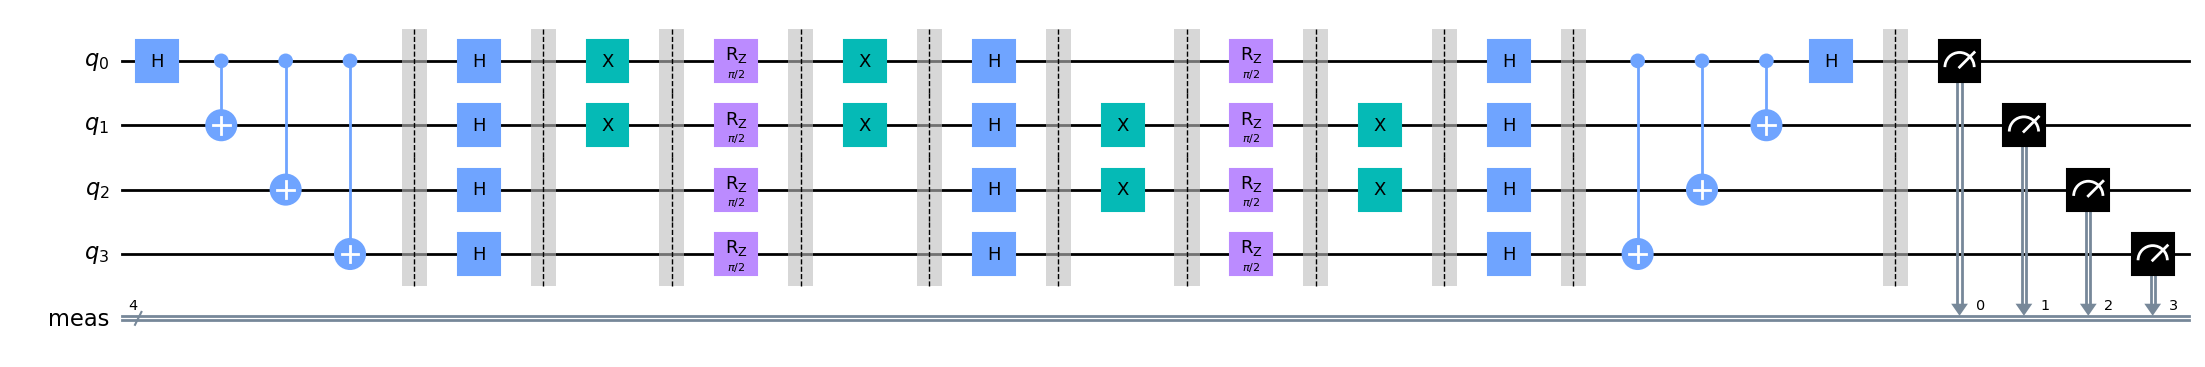

In [14]:
qc_e = circ_gen.create_grover_enc_circuit('10')
qc_e.measure_all()
qc_e.draw(fold=-1, output='mpl')

/Users/dohuynhn/miniconda3/envs/helmi/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/dohuynhn/miniconda3/envs/helmi/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/dohuynhn/miniconda3/envs/helmi/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


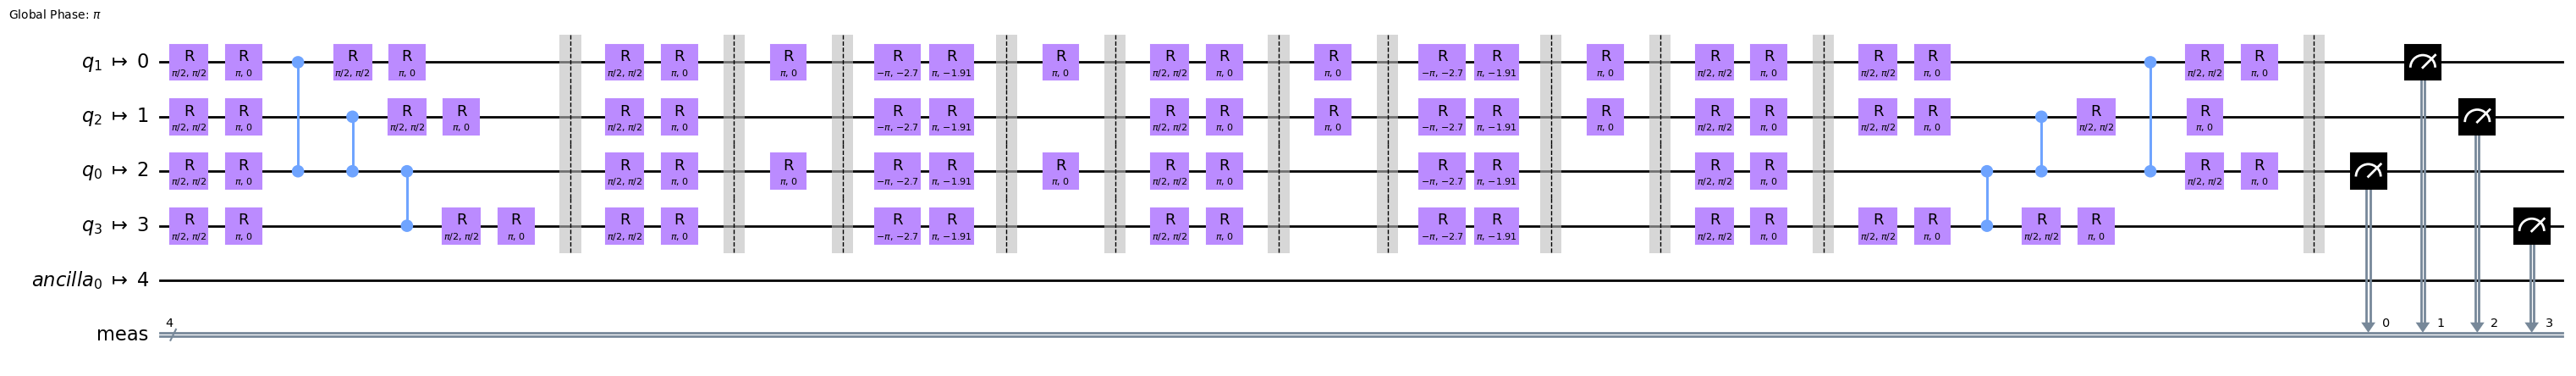

In [16]:
# As the circuit is already follow the Helmi QPU's topology, the transpiled circuit does not need any Swap gates
transpiled = utils.transpile_circuit(qc_e, backend)
transpiled.draw(fold=-1, output='mpl')

# Measurement output

Given a measurement bitstring $b = b_0 b_1 b_2 b_3$, the eigenvalue of the observable $Z_i$ is $(-1)^{b_i}$, for example, the eigenvalue of $Z_1$ is  $(-1)^{b_1}$ [2](#reference) . The logical outcomes are given by the eigenvalues of $\overline{Z_0}$ and $\overline{Z_1}$, therefore, $b_1 b_2$ representing the logical outcome value.

The eigenvalue of stabilizer $\overline{X}$ is $(-1)^{b_0}$ , and for stabilizer $\overline{Z}$   is $(-1)^{b_1 + b_2 + b_3}$. The error syndromes corresponding to these stabilizers are given by:
$$ \begin{equation}
s_1 = b_0; \quad s_2 = b_1 + b_2 + b_3 \end{equation}$$
According to this formula, we have a table of measurement bitstrings and corresponding error syndromes

| Measurement Bitstrings $b_0 b_1 b_2 b_3$ | Error Syndromes $s_1 s_2$ |
| ---------------------------------------- | ------------------------- |
| {0000, 0011, 0101, 0110}                 | 00                        |
| {0001, 0010, 0100, 0111}                 | 01                        |
| {1000, 1011, 1101, 1110}                 | 10                        |
| {1001, 1010, 1100, 1111}                 | 11                        |

If there is no error occur in the circuit (here excluding the errors in encoding, decoding and measurement stages), where $s_1 = s_2 = 0$, the expected output of the Grover search circuit would be:

| Marked State | Measurement Output |
|--------------|--------------------|
| 00           | 0000               |
| 01           | 0011               |
| 10           | 0101               |
| 11           | 0110               |

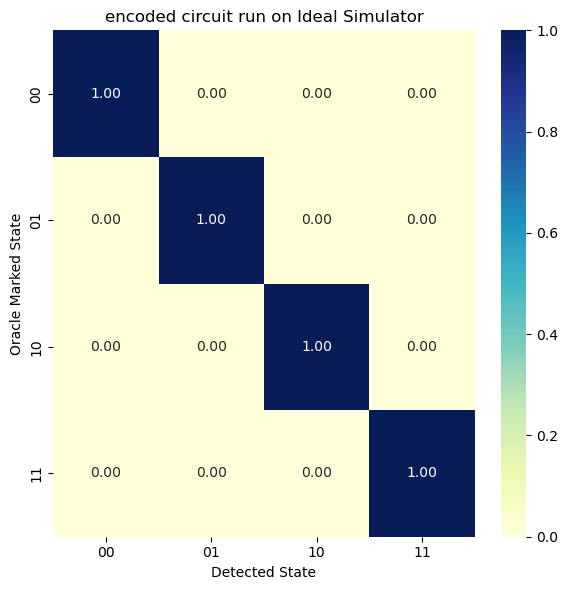

In [11]:
# Marked bitstring onto logical qubits encoded code
bitstring_enc_dict = {'00': '0000', '01': '0011', '10': '0101', '11': '0110'}

acc_map_e, plot_title_e = utils.run_and_get_accuracy_map(bitstring_enc_dict, ideal_simulator, type='encoded', shots=shots)
utils.plot_heatmap(acc_map_e, plot_title_e) 

# Unencoded circuit

To compare the performance of the encoded and unencoded versions of the circuit, we ran both on the Helmi quantum computer. For a fair comparison, we duplicated the Grover's 2-bit search circuit to match the qubit count of the encoded version.

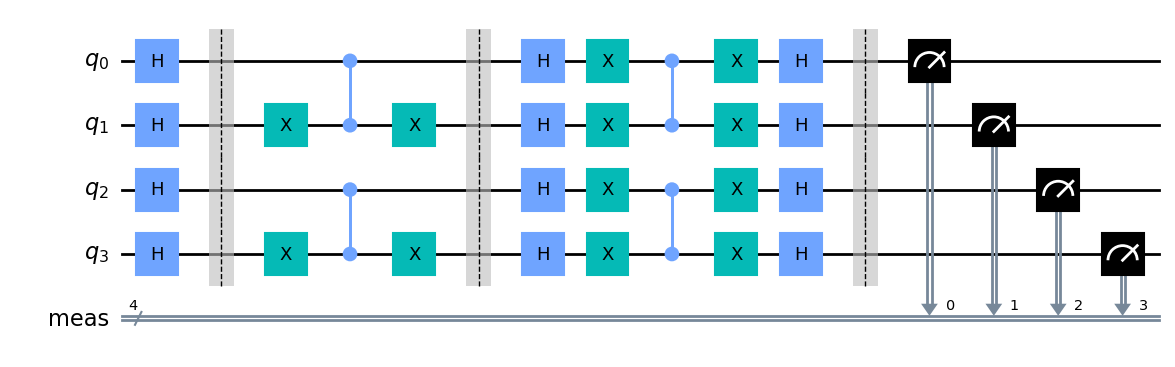

In [12]:
qc_u = circ_gen.create_grover_unenc_circuit('10', 4)
qc_u.measure_all()
qc_u.draw(fold=-1, output='mpl', style='clifford')

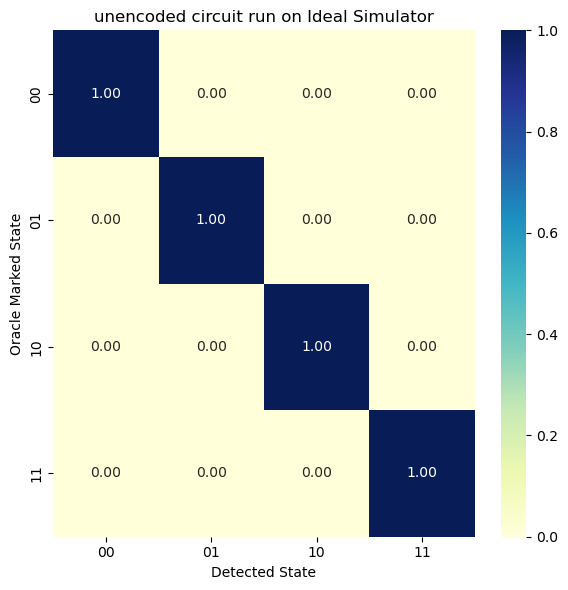

In [13]:
# Marked bitstring onto physical qubits in unencoded code 
bitstring_unenc_dict = {'00': '0000', '01': '0101', '10': '1010', '11': '1111'}

acc_map_u, plot_title_u = utils.run_and_get_accuracy_map(bitstring_unenc_dict, ideal_simulator, "unencoded", shots)
utils.plot_heatmap(acc_map_u, plot_title_u)

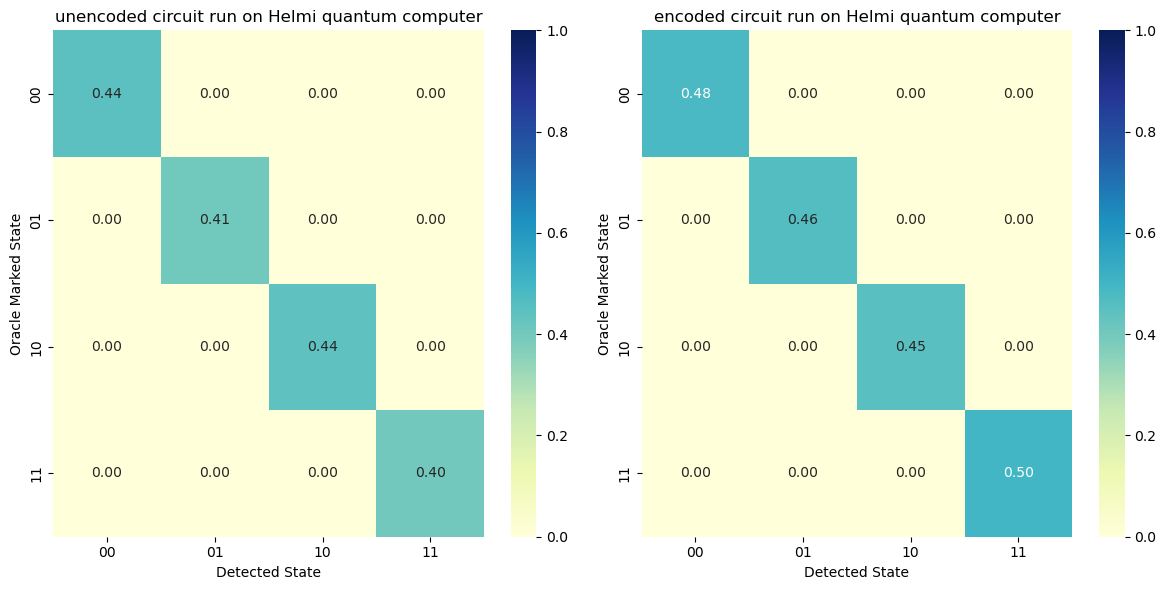

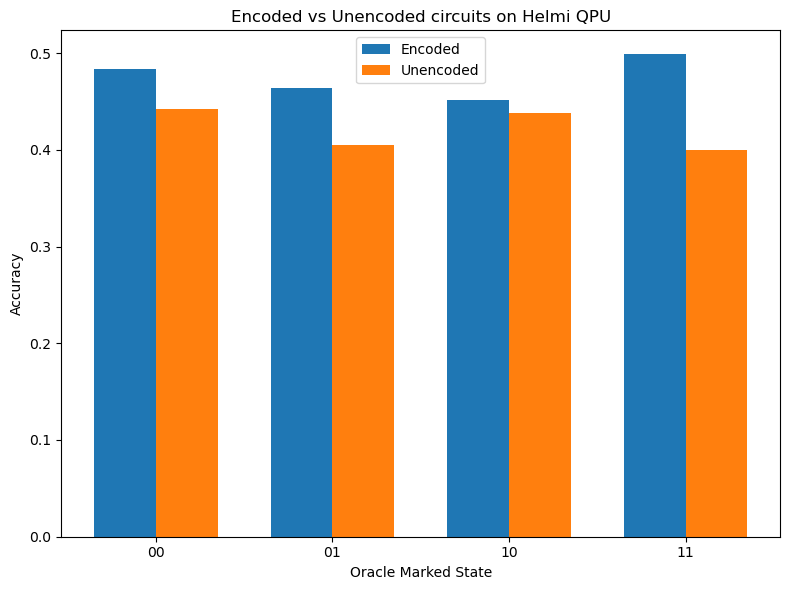

In [21]:
# Run on Helmi QPU

acc_map_e, plot_title_e = utils.run_and_get_accuracy_map(dict=bitstring_enc_dict, backend=backend, type='encoded', shots=shots)
acc_map_u, plot_title_u = utils.run_and_get_accuracy_map(dict=bitstring_unenc_dict, backend=backend, type='unencoded', shots=shots)

utils.plot_heatmap(acc_map_u, plot_title_u, acc_map_e, plot_title_e)
utils.plot_bargraph(acc_map_e, "Encoded",  acc_map_u, "Unencoded", "Encoded vs Unencoded circuits on Helmi QPU")

# Evaluate the performance

In [23]:
accuracy_u = []
accuracy_e = []
epochs = 5

qc_e = circ_gen.create_grover_enc_circuit('11')
qc_e.measure_all()

qc_u = circ_gen.create_grover_unenc_circuit('11')
qc_u.measure_all()

for i in range(epochs):
    count_u, plot_title_u = utils.run_a_circuit(qc_u, backend, type="unencoded", shots=shots)
    acc_u = count_u.get(bitstring_unenc_dict['11'], 0)/shots
    accuracy_u.append(acc_u)
    
    count_e, plot_title_e = utils.run_a_circuit(qc_e, backend, type="encoded", shots=shots)
    acc_e = count_e.get(bitstring_enc_dict['11'], 0)/shots
    accuracy_e.append(acc_e)
    
    print(f"Epoch {i}, unencoded accuracy: {acc_u}, encoded accuracy: {acc_e}")


print("\nEvaluate the performance on Helmi")
print("Unencoded accuracy: ", np.mean(accuracy_u).round(2))
print("Encoded accuracy: ", np.mean(accuracy_e).round(2))

Epoch 0, unencoded accuracy: 0.3698, encoded accuracy: 0.4996
Epoch 1, unencoded accuracy: 0.3863, encoded accuracy: 0.4836
Epoch 2, unencoded accuracy: 0.3684, encoded accuracy: 0.4974
Epoch 3, unencoded accuracy: 0.3724, encoded accuracy: 0.476
Epoch 4, unencoded accuracy: 0.3566, encoded accuracy: 0.4899

Evaluate the performance on Helmi
Unencoded accuracy:  0.37
Encoded accuracy:  0.49


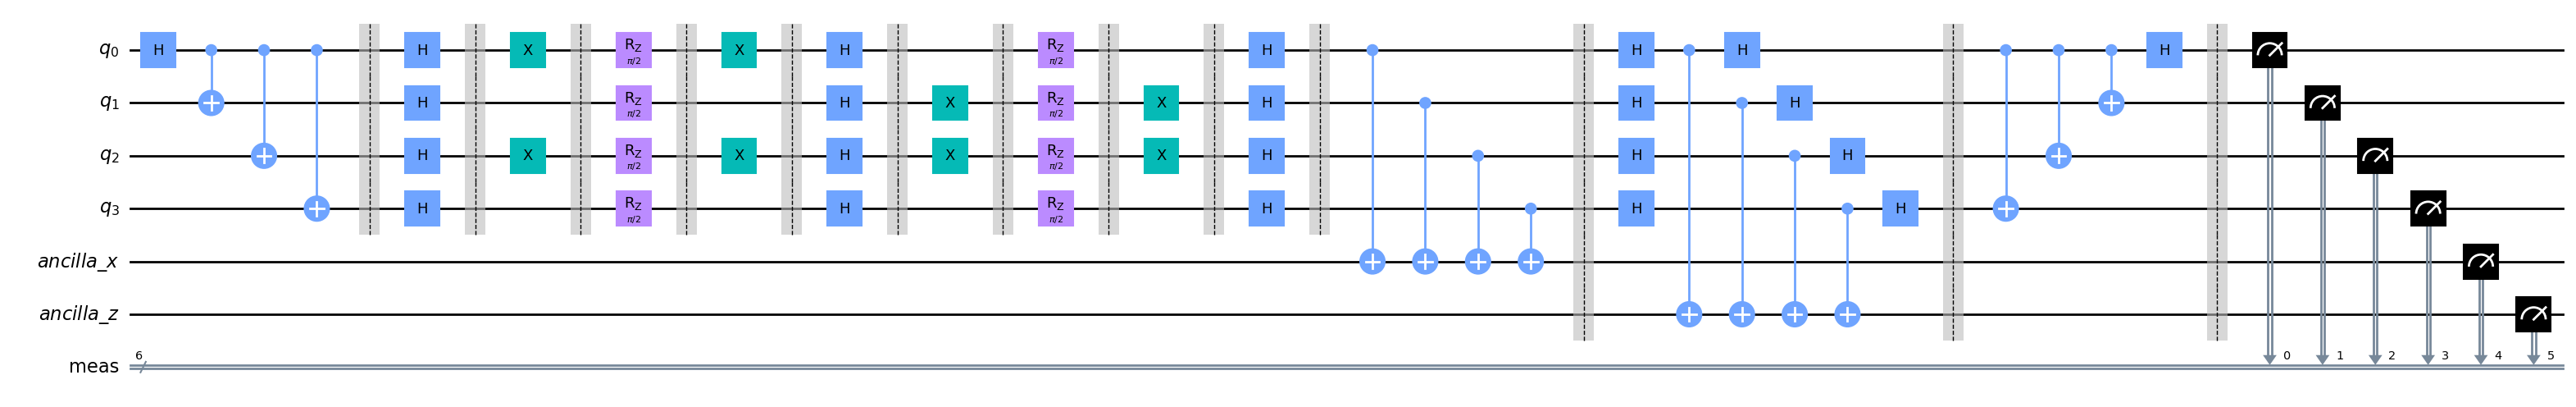

In [7]:
# If we want to add syndrome qubits to the circuit, we can use the following function

circ1 = circ_gen.create_grover_enc_circuit('01', enc_ver=1, add_syndrome=True)
circ1.measure_all()
circ1.draw(fold=-1, output='mpl', style='clifford')

# References

1. L. K. Grover, "Quantum mechanics helps in searching for a needle in a haystack," Phys. Rev. Lett., vol. 79, pp. 325-328, Jul. 1997. Available: https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.79.325
2. A. Chatterjee, S. Das, and S. Ghosh, "Q-Pandora Unboxed: Characterizing Noise Resilience of Quantum Error Correction Codes,", Aug. 2023. Available: https://arxiv.org/pdf/2308.02769
3. B. Pokharel and D. A. Lidar, "Better-than-classical Grover search via quantum error detection and suppression," npj Quantum Inf., vol. 9, no. 1, Mar. 2023. Available: https://www.nature.com/articles/s41534-023-00794-6
4. E. G. Rieffel, D. A. Lidar, and A. Y. Matsuura, "Error detection on quantum computers improves accuracy of chemical calculations," arXiv:1910.00129, Oct. 2019. Available: https://arxiv.org/pdf/1910.00129
5. A. R. Calderbank and P. W. Shor, "Error prevention scheme with four particles," arXiv:quant-ph/9603031, Mar. 1996. Available: https://arxiv.org/pdf/quant-ph/9603031
6. D. Gottesman, "Protecting quantum memories using coherent parity check codes," arXiv:1709.01866, Sep. 2017. Available: https://arxiv.org/pdf/1709.01866#page=15.52
7. E. Hu, Z. Li, and R. Shapiro, "Quantum Benchmarking on the [[4,2,2]] Code," Duke University, Department of Mathematics, 2018. Available: https://services.math.duke.edu/DOmath/DOmath2018/hu-li-shapiro.pdf
8. A. D. Corcoles et al., "Fault-tolerant quantum error detection," Sci. Adv., vol. 3, no. 7, Jul. 2017. Available: https://www.science.org/doi/epdf/10.1126/sciadv.1701074
